In [1]:
import os
import numpy as np
import trimesh

class CaseLoader:
    """
    A class to load and process 3D geometry data from a folder, perform transformations, 
    and export corrected fragments.
    """
    def __init__(self, folder_path: str, stats_for_nerds: bool = False) -> None:
        """
        Initializes the CaseLoader with the path to the folder containing 3D data.

        Args:
            folder_path (str): Path to the folder containing the case data.
            stats_for_nerds (bool, optional): Flag to print additional debugging information. Defaults to False.
        """
        self.stats_for_nerds = stats_for_nerds
        self.folder_path = folder_path
        self.path_dict = {"experiment": [], "fragments": [], "corrected_fragments": []}

        # Extract case name from folder path and initialize path_dict
        case = folder_path.split('/')[-1]
        self.path_dict["experiment"].append(case)

        # Collect fragment paths
        fragment_folder = f"{folder_path}/fragments"
        for fragment in os.listdir(fragment_folder):
            if ".DS_Store" not in fragment:
                self.path_dict["fragments"].append(os.path.join(fragment_folder, fragment))

        # Define rotation matrix for a 180-degree rotation around the X-axis
        angle = np.pi  # 180 degrees in radians
        self.rotation_matrix = np.array([
            [1, 0, 0, 0],  # X-axis remains the same
            [0, np.cos(angle), -np.sin(angle), 0],  # Rotate YZ
            [0, np.sin(angle), np.cos(angle), 0],
            [0, 0, 0, 1]   # Homogeneous coordinate
        ])

        # Process the case immediately when the object is initialized
        self.process_case()

    def get_center_line(self, vertices: np.ndarray, stats_for_nerds: bool) -> np.ndarray:
        """
        Calculate the centerline of a set of vertices based on PCA and visualize the result if required.

        Args:
            vertices (np.ndarray): Array of 3D vertices.
            stats_for_nerds (bool): Flag to print debugging information and visualize the results.

        Returns:
            np.ndarray: The 95th percentile point on the trendline.
        """
        # Convert vertices into a Trimesh Point Cloud
        point_cloud = trimesh.points.PointCloud(vertices)

        # Compute the centroid (mean point of all vertices)
        centroid = point_cloud.centroid

        # Perform Principal Component Analysis (PCA)
        cov_matrix = np.cov(vertices.T)  # Transpose for covariance calculation
        eigenvalues, eigenvectors = np.linalg.eig(cov_matrix)

        # Find the principal eigenvector (largest eigenvalue)
        principal_eigenvector = eigenvectors[:, np.argmax(eigenvalues)]

        # Parametric equation: L(t) = centroid + t * principal_eigenvector
        def trendline_point(t: float) -> np.ndarray:
            return centroid + t * principal_eigenvector

        # Find the vertices with the highest and lowest Z-values
        highest_z_index = vertices[:, 2].argmax()
        highest_z_vertex = vertices[highest_z_index]

        lowest_z_index = vertices[:, 2].argmin()
        lowest_z_vertex = vertices[lowest_z_index]

        # Generate points along the trendline
        t_values = np.linspace(lowest_z_vertex[-1], highest_z_vertex[-1], 100)
        trendline_points = np.array([trendline_point(t) for t in t_values])

        # Extract the 95th percentile point along the trendline
        top_5 = trendline_points[95]

        if stats_for_nerds:
            # Print and visualize results if required
            print("Centroid of points:", centroid)
            print("Direction of trendline:", principal_eigenvector)
            print(f"95% coords: {top_5}")

            try:
                # Optional: Visualize with matplotlib
                import matplotlib.pyplot as plt

                fig = plt.figure()
                ax = fig.add_subplot(111, projection='3d')

                # Plot original points
                ax.scatter(vertices[:, 0], vertices[:, 1], vertices[:, 2], label='Original Points', color='blue', alpha=0.01)

                # Plot trendline
                ax.plot(trendline_points[:, 0], trendline_points[:, 1], trendline_points[:, 2], label='Trendline', color='red', alpha=1)

                # Plot 95th percentile
                ax.plot(top_5[0], top_5[1], top_5[2], marker='o', label='95th percentile', color='green')

                # Label axes
                ax.set_xlabel('X')
                ax.set_ylabel('Y')
                ax.set_zlabel('Z')

                plt.legend()
                plt.show()
            except ImportError:
                print("Matplotlib not installed; cannot visualize the result.")

        return top_5

    def process_case(self) -> None:
        """
        Processes the 3D case by loading fragments, calculating geometric transformations,
        applying them, and exporting corrected fragments to a new directory.
        """
        # Load all the fragment meshes into the scene
        combined_meshes = [trimesh.load(fragment) for fragment in self.path_dict['fragments']]
        scene = trimesh.Scene(combined_meshes)

        # Initialize total volume and weighted center sum for the scene
        total_volume = 0
        weighted_center_sum = np.zeros(3)

        # Calculate the total volume and weighted center of mass for all geometries in the scene
        for geometry_name, geometry in scene.geometry.items():
            if isinstance(geometry, trimesh.Trimesh):
                volume = geometry.volume
                center_of_mass = geometry.center_mass
                total_volume += volume
                weighted_center_sum += center_of_mass * volume

        # Calculate the center of volume for the entire scene
        if total_volume > 0:
            center_of_volume = weighted_center_sum / total_volume
        else:
            raise ValueError("The total volume of the scene is zero or no valid geometry found!")

        # Create and apply a translation matrix to shift the center of mass to the origin
        translation_matrix = np.eye(4)
        translation_matrix[:3, 3] = -center_of_volume
        for geometry_name, geometry in scene.geometry.items():
            if isinstance(geometry, trimesh.Trimesh):
                geometry.apply_transform(translation_matrix)
                geometry.apply_transform(self.rotation_matrix)

        # Process fragments with 'shaft' in their name to calculate the centerline
        for geometry_name, geometry in scene.geometry.items():
            if isinstance(geometry, trimesh.Trimesh) and "shaft" in geometry_name:
                vertices = geometry.vertices
                top_20 = self.get_center_line(vertices, self.stats_for_nerds)

        # Apply a final translation to align with the 95th percentile
        translation_matrix = np.eye(4)
        translation_matrix[:3, 3] = -top_20
        for geometry_name, geometry in scene.geometry.items():
            if isinstance(geometry, trimesh.Trimesh):
                geometry.apply_transform(translation_matrix)

        # Export the corrected fragments to a new folder
        export_folder = self.folder_path.replace("data", "new_data")
        os.makedirs(export_folder, exist_ok=True)
        for geometry_name, geometry in scene.geometry.items():
            corrected_path = f"{export_folder}/{geometry_name}"
            self.path_dict['corrected_fragments'].append(corrected_path)
            geometry.export(corrected_path)


Centroid of points: [-0.06117164  0.47390971 -9.61807371]
Direction of trendline: [-0.11025957 -0.10115404  0.98874197]
95% coords: [-10.00571107  -8.64938343  79.55861612]


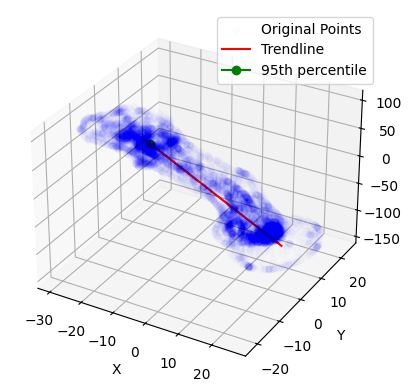

In [2]:
case2 = CaseLoader('/Users/bogdanmatache/Documents/GitHub/2024-25ab-fai3-specialisation-project-team-specifix-1/new_environment/data/F114', True)